In [1]:
from matplotlib import font_manager
import seaborn as sns
import numpy as np
import pandas as pd
from os.path import isfile
import warnings
warnings.filterwarnings('ignore')
font_manager.fontManager.addfont("C:\Windows\Fonts\FiraSans-Regular.ttf")

sns.set_theme()
sns.set(font="Fira Sans")

Image credits: [Christina Animashaun/Vox](https://www.vox.com/recode/2020/2/18/21121286/algorithms-bias-discrimination-facial-recognition-transparency)

Instructions can be found at [Auditing Allocative Bias](https://middlebury-csci-0451.github.io/CSCI-0451/assignments/blog-posts/blog-post-bias-allocative.html).

## Problem statement
We grab datasets derived from the US Census, courtesy of the [folktables](https://github.com/socialfoundations/folktables) package.

We can use `BasicProblem()` to frame a problem for our investigation.

In this case, we attempt to predict employment status on the basis of demographics, **excluding race**, in the US state of California.

Since we are looking at employment, it would make sense to only look at people between the ages of 16 and 90.

Then, we audit for racial bias in our predictions.

(The code chunk below is derived from the [blog post instructions](https://middlebury-csci-0451.github.io/CSCI-0451/assignments/blog-posts/blog-post-bias-allocative.html#what-you-should-do).)

In [2]:
# Data
from folktables import ACSDataSource, BasicProblem

STATE = "CA"


def age_filter(data):
    """Age filter.
    """
    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['AGEP'] < 90]
    return df


data_source = ACSDataSource(
    survey_year='2018',
    horizon='1-Year',
    survey='person'
)

file_exists = isfile("./data/2018/1-Year/psam_p06.csv")
acs_data = data_source.get_data(states=[STATE], download=not file_exists)

possible_features = [
    'AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG',
    'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'ESR'
]

features_to_use = [
    f for f in possible_features
    if f not in ["ESR", "RAC1P"]
]

EmploymentProblem = BasicProblem(
    features=features_to_use,
    target='ESR',
    target_transform=lambda x: x == 1,
    group='RAC1P',
    preprocess=age_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

features, label, group = EmploymentProblem.df_to_numpy(acs_data)

Then, we perform a train-test split:

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, \
    y_train, y_test, \
    group_train, group_test = train_test_split(
        features,
        label,
        group,
        test_size=0.2,
        random_state=0
    )

## Data descriptives
We answer some descriptive questions about the data.
In order to do this, we convert our training set back into a dataframe:

In [4]:
df = pd.DataFrame(X_train, columns=features_to_use)
df["group"] = group_train
df["label"] = y_train

df.head()

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,group,label
0,39.0,21.0,3.0,0.0,2.0,0.0,1.0,1.0,4.0,1.0,1.0,2.0,2.0,2.0,2.0,1,True
1,63.0,22.0,1.0,0.0,1.0,0.0,1.0,1.0,4.0,2.0,1.0,1.0,2.0,2.0,2.0,1,False
2,36.0,21.0,1.0,0.0,2.0,0.0,1.0,1.0,4.0,4.0,1.0,2.0,2.0,2.0,2.0,1,True
3,17.0,14.0,5.0,2.0,2.0,1.0,1.0,1.0,4.0,2.0,1.0,2.0,2.0,2.0,1.0,9,False
4,78.0,21.0,3.0,0.0,2.0,0.0,4.0,1.0,4.0,1.0,2.0,2.0,2.0,2.0,2.0,6,False


::: {.callout-tip appearance="simple" collapse="true"}
### Column definitions (click to expand)
These are the column definitions from Appendix B.2 of [the original paper](https://arxiv.org/pdf/2108.04884.pdf):

- AGEP: age
- SCHL: education, from 1 (none) to 24 (doctorate degree)
- MAR, RELP: marital & relationship status
- DIS, DEAR, DEYE, DREM: disabilities
- ESP: employment status of parents
- CIT: citizenship
- MIG: mobility status
- MIL: military service
- ANC: ancestry
- SEX: 1 for male, 2 for female
- label: employed (`True`) or unemployed (`False`)

The `group` column encodes race as follows:

1. White alone
2. Black or African American alone
3. American Indian alone
4. Alaska Native alone
5. American Indian and Alaska Native tribes specified, or American Indian or Alaska Native, not specified and no other races
6. Asian alone
7. Native Hawaiian and Other Pacific Islander alone
8. Some Other Race alone
9. Two or More Races
:::

We can use `pandas.DataFrame.describe` to get some basic descriptive statistics:

In [5]:
df[[df.columns[0]]].describe()

,AGEP
count,242112.000000
mean,47.426612
std,18.480978
min,17.000000
25%,32.000000
50%,47.000000
75%,62.000000
max,89.000000


Since `AGEP` (age) is quantitiative, `describe` gives us the age percentiles.

[We can see 242,112 people in the dataset]{.text-warning}, with age ranging from 17 to 89 (as filtered), and averaging at 47.42.

Then, we look at the other columns, which are qualitative:

In [6]:
# https://stackoverflow.com/a/37717675
summary = df.drop(columns="AGEP", axis=1).astype(int).astype(str).describe()

# percentage of mode
summary.loc["percent"] = (summary.loc["freq"] /
                          summary.loc["count"] * 100).astype(float).round(2)
summary

# I miss R, they have f-strings but for markdown
# I realize I included children, but too late
# so now I have to manually edit every single number
# https://quarto.org/docs/computations/execution-options.html#inline-code

,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,group,label
count,242112,242112,242112,242112,242112,242112,242112,242112,242112,242112,242112,242112,242112,242112,242112,242112
unique,24,5,18,2,9,5,3,4,4,2,2,2,2,2,9,2
top,21,1,0,2,0,1,1,4,1,1,2,2,2,2,1,1
freq,49765,123618,106112,209200,238702,163044,210673,225554,151602,166490,233094,236350,229852,123410,151265,138066
percent,20.55,51.06,43.83,86.41,98.59,67.34,87.01,93.16,62.62,68.77,96.28,97.62,94.94,50.97,62.48,57.03


This table gives us insight into the different qualitative categories.

For example:

- `SCHL`: the most common level of education in our dataset is 21 ("Bachelor's degree") at 49,765 people (20.55%).
- `CIT`: the majority of people (163,044, 67.34	%) in our dataset were born in the U.S.
- `group`: 62.48% of our dataset (151,265 people) are White.
- `label`: 57.03% of people in our dataset are unemployed. Therefore, [42.97% of people in our dataset are employed]{.text-warning}.

We can then [look at each group]{.text-warning} with `pandas.DataFrame.value_counts`:

In [7]:
# this took so much googling
# now I really miss R
# https://stackoverflow.com/a/69573365
freq = df[["group", "label"]].value_counts().unstack(fill_value=0)
freq["Total"] = freq[False] + freq[True]
perc = df[["group", "label"]].value_counts(
    normalize=True).unstack(fill_value=0)
# Total and in_group percentages
perc["Total"] = (freq[False] + freq[True]) / df.shape[0]
perc["True_in_group"] = freq[True] / (freq[False] + freq[True])
perc["False_in_group"] = 1 - perc["True_in_group"]

# https://stackoverflow.com/a/53679333
pd.concat([freq, perc * 100], axis=1, keys=['counts', '%']).round(3)

counts                      %                                \
label  False   True   Total   False    True   Total True_in_group   
group                                                               
1      66113  85152  151265  27.307  35.170  62.477        56.293   
2       6303   5749   12052   2.603   2.375   4.978        47.702   
3        929    884    1813   0.384   0.365   0.749        48.759   
4         12      7      19   0.005   0.003   0.008        36.842   
5        244    304     548   0.101   0.126   0.226        55.474   
6      15837  23588   39425   6.541   9.743  16.284        59.830   
7        332    454     786   0.137   0.188   0.325        57.761   
8      10551  16315   26866   4.358   6.739  11.097        60.727   
9       3725   5613    9338   1.539   2.318   3.857        60.109   

                      
label False_in_group  
group                 
1             43.707  
2             52.298  
3             51.241  
4             63.158  
5             44.526  
6             40.170  
7             42.239  
8             39.273  
9             39.891

The interpretation of this table is fairly straighforward.

For example, of our dataset, 62.477% (151,265 people) is from group 1 (White alone), 35.170% (85,152 people) are employed, and 27.307% (66,113 people) are unemployed.

Inside group 1, 56.293% are employed, so 43.707% are not.

### Intersectional trends
#### Sex
We now look at employment data that is broken out by our group variable (race) and other variables.

First, employment by race and sex:

Text(0.5, 12.444444444444416, 'Sex')

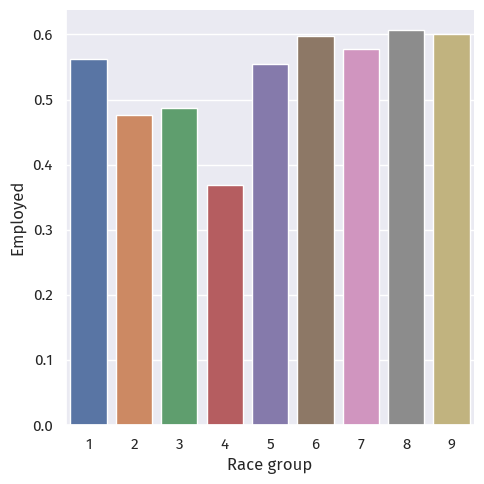

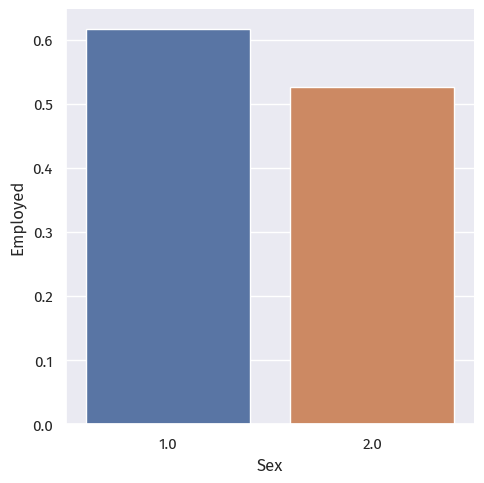

In [8]:
p = sns.catplot(data=df, x="group", y="label", kind="bar", errorbar=None)
axes = p.axes.flatten()
axes[0].set_ylabel("Employed")
axes[0].set_xlabel("Race group")

p = sns.catplot(data=df, x="SEX", y="label", kind="bar", errorbar=None)
axes = p.axes.flatten()
axes[0].set_ylabel("Employed")
axes[0].set_xlabel("Sex")

We observe stark differences between the different race and sex groups.

The employment rate for race group 4 (Alaska Native alone) is particularly low; this may or may not be explained by the small sample size of 19 people.

Text(0.5, 34.062499999999986, 'Race group')

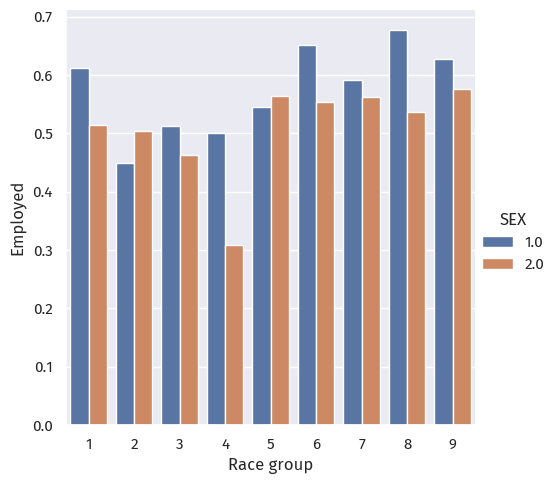

In [9]:
p = sns.catplot(data=df, x="group", y="label", hue="SEX", kind="bar", errorbar=None)
axes = p.axes.flatten()
axes[0].set_ylabel("Employed")
axes[0].set_xlabel("Race group")

Putting race and sex together, we still observe a clear difference between employment rates across groups.

As for sex across race groups, only groups 2 (Black or African American alone) and 5 (American Indian and Alaska Native tribes specified) have more female employment than men.
In other race groups, men are more employed.

#### Military service

Text(0.5, 34.062499999999986, 'Race group')

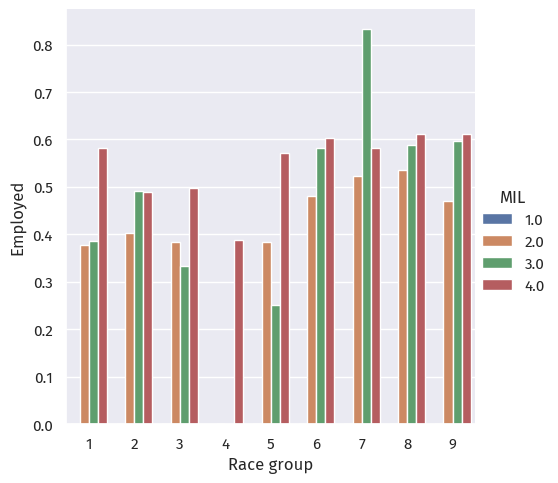

In [10]:
p = sns.catplot(data=df, x="group", y="label", hue="MIL", kind="bar", errorbar=None)
axes = p.axes.flatten()
axes[0].set_ylabel("Employed")
axes[0].set_xlabel("Race group")

When grouped by military service, we see that:


## Model training
We will be using `sklearn.svm.SVC`, a C-Support Vector Classification model, to predict employment based on the predictors [mentioned above](#data-descriptives).

C, the regularization parameter, is a hyperparameter that will be selected with `sklearn.model_selection.StratifiedShuffleSplit`.
The score used will be area under the ROC curve; the search space is a `log-uniform` distribution from `1e-6` to `1e+6`.

Here we use an optimized Bayesian Optimization from `scikit-optimize` to hopefully achieve faster results.

In [15]:
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC

rfc = RandomForestClassifier(random_state=42)
# svc = SVC(random_state=42)

grid = {"max_depth": (5, 15)}
# grid = {"C": (1e-6, 1e+6, "log-uniform")}
# grid = {"C": [1, 2, 3, 4, 5]}

# cv = StratifiedShuffleSplit(n_splits=5, test_size=20, train_size=100, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = BayesSearchCV(rfc, grid, scoring="roc_auc", cv=cv, n_jobs=-2)
# search = GridSearchCV(svc, grid, scoring="roc_auc", cv=cv, n_jobs=-2)
search.fit(X_train, y_train)
# rfc.fit(X_train, y_train)